##### from sklearn.impute import SimpleImputer
from joblib import dump, load

#from base1 import *
from base2 import *

X_train_1 = pd.read_csv('csv/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X140")

# Calculate frequency encoding on the training set
frequency_encoding = X_train['X140'].value_counts(normalize=True)
# Map the frequencies to the sector column in each dataset
X_train['X141'] = X_train['X140'].map(frequency_encoding)
X_val['X141'] = X_val['X140'].map(frequency_encoding)
X_test['X141'] = X_test['X140'].map(frequency_encoding)
# Fill any missing values that might arise if a category in val/test wasn't in train
X_val['X141'].fillna(0, inplace=True)
X_test['X141'].fillna(0, inplace=True)

# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

# Deal with missing values in the features 
missing_threshold = 0.2
missing_train = X_train.isnull().mean()
cols_to_drop = missing_train[missing_train > missing_threshold].index
# Drop the identified columns from both the training and test sets
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(f"Columns dropped: {list(cols_to_drop)}")

col_names = X_train.columns.to_list()
col_names.remove("X23")

# remove outliers
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= 20)
print("Rows removed per class:", removed_counts)

# Deal with missing values
max_missing = 17
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]

# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

"""imputer = IterativeImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
"""
# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


# Use SMOTE to oversample the minority class in the training set
smote = SMOTE()
X_train_resampled, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", pd.Series(y_train.value_counts()))

# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train_resampled, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")

X_train_full, X_val_full, X_test_full, explained_variance, eigenvalues = k.pca_on_train_and_transform_full_data(X_train, X_val, X_test)

pca_table = k.create_pca_table(explained_variance, eigenvalues)
print(pca_table)

# Select columns
X_train_svm = X_train_full.iloc[:, :19]
X_val_svm = X_val_full.iloc[:, :19]
X_test_svm = X_test_full.iloc[:, :19]

"""# Load the saved SVM model
svm_rbf_loaded = load("svm_rbf_model_1112.joblib")
# Verify by running predictions
y_test_pred_loaded = svm_rbf_loaded.predict(X_test_svm)
print(classification_report(y_test, y_test_pred_loaded))"""

# Create an SVM classifier with RBF kernel (Saeedi, 2021)
svm_rbf = SVC(kernel='rbf', probability=True)
"""# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(svm_rbf, X_train_svm, y_train, cv=10)
# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())"""
# Train the SVM model on the full training set
svm_rbf.fit(X_train_svm, y_train)
# Evaluate on the validation set
y_val_pred = svm_rbf.predict(X_val_svm)
print("Validation set classification report:")
print(classification_report(y_val, y_val_pred))
# Optionally, you can evaluate on the test set as well
y_test_pred = svm_rbf.predict(X_test_svm)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

  0%|          | 0/50 [00:00<?, ?it/s]

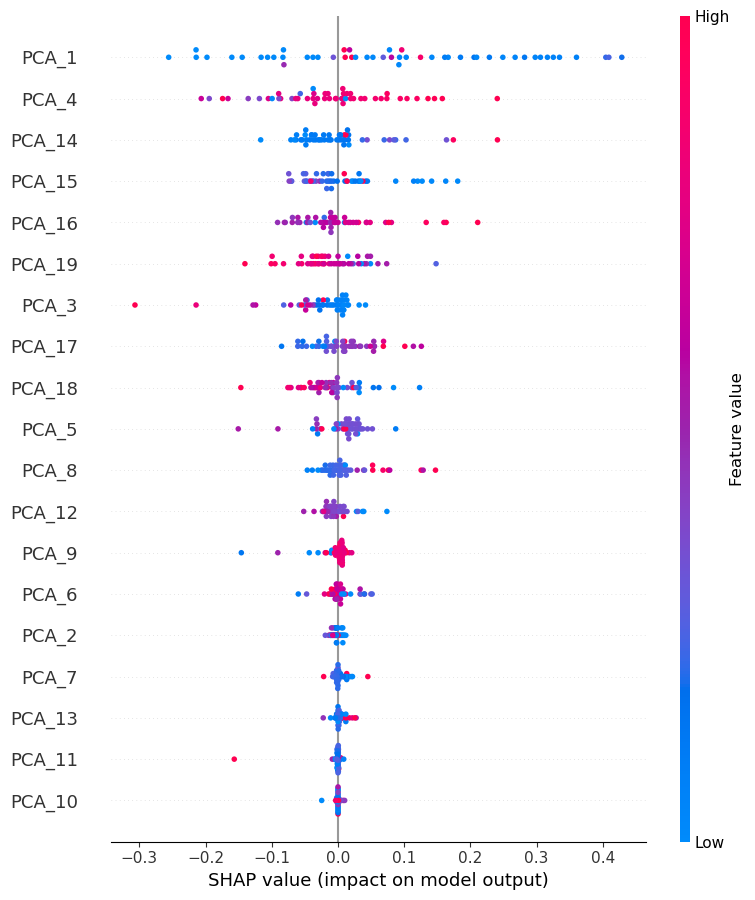

Elapsed time: 5438.6028 seconds


In [ ]:
import time

# Start the timer
start_time = time.time()

# XAI
# Create a SHAP KernelExplainer for the SVM model
background_data = shap.sample(X_train_svm, 50)
explainer = shap.KernelExplainer(svm_rbf.predict_proba, background_data)
# Compute SHAP values for the test set
X_test_svm_shap = shap.sample(X_test_svm, 50)
shap_values = explainer.shap_values(X_test_svm_shap)  # Use nsamples to control computation time
# Global interpretability
shap.summary_plot(shap_values[:,:,1], X_test_svm_shap)  # For the positive class (index 1)

# Local interpretability for a specific instance
sample_index = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[:,:,1][sample_index],
    X_test_svm.iloc[sample_index]
)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

In [ ]:
# Local interpretability for a specific instance
sample_index = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[:,:,1][sample_index],
    X_test_svm.iloc[sample_index]
)

In [ ]:
shap_values

array([[[-0.103024  ,  0.103024  ],
        [-0.00148535,  0.00148535],
        [-0.01337696,  0.01337696],
        ...,
        [-0.05397646,  0.05397646],
        [ 0.00097784, -0.00097784],
        [ 0.04144604, -0.04144604]],

       [[ 0.21419405, -0.21419405],
        [ 0.00206852, -0.00206852],
        [ 0.12838261, -0.12838261],
        ...,
        [-0.01746612,  0.01746612],
        [-0.03168875,  0.03168875],
        [ 0.0547972 , -0.0547972 ]],

       [[-0.16636512,  0.16636512],
        [-0.00803686,  0.00803686],
        [-0.0142378 ,  0.0142378 ],
        ...,
        [-0.1137997 ,  0.1137997 ],
        [-0.02086809,  0.02086809],
        [ 0.10102399, -0.10102399]],

       ...,

       [[-0.31627041,  0.31627041],
        [ 0.01016415, -0.01016415],
        [ 0.02751075, -0.02751075],
        ...,
        [-0.022057  ,  0.022057  ],
        [-0.01394506,  0.01394506],
        [-0.00159163,  0.00159163]],

       [[-0.14173036,  0.14173036],
        [ 0.00437617, -0.00